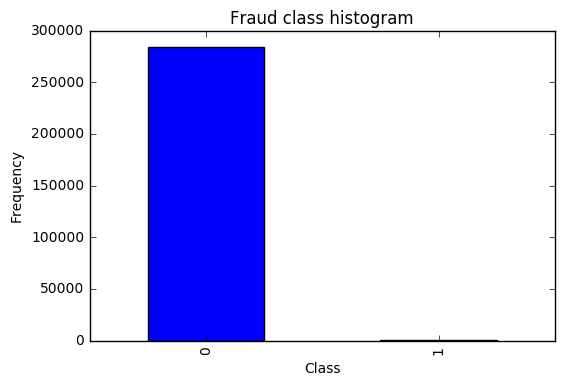

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
% matplotlib inline

os.chdir('C:/Users/qg186002/Documents/ipython')

data=pd.read_csv('creditcard.csv')

#data exploration 
#label extremely skewed
#pd.value_counts: groupby value
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()


#matplotlib
count_classes.plot(kind = 'bar')h
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [8]:
from sklearn.preprocessing import StandardScaler
#1.normalising amount column. Other features are all normalied pca features
data['normAmount']=StandardScaler().fit_transform(data['Amount'].reshape(-1,1))
#reshape(-1,1)  [1,2,3,4] (4,) -> [[1],[2],[3],[4]]

data=data.drop(['Time','Amount'],1)

#2.Assigning X and Y. No resampling. 
X=data.ix[:,data.columns!='Class']  # features
y=data.ix[:,data.columns=='Class']


# class=0 : normal  ; class=1 : fraud
number_records_fraud=len(data[data.Class==1])

fraud_indices=np.array(data[data.Class==1].index)

normal_indices=data[data.Class==0].index

In [9]:
#3.randomly resamplinng: via indices np.random.choice()
#SMOTE: synthetic Minority Over-Sampling Technique: hybrid of under + oversampling8
#not like oversampling by replicating minority class, but by constructing new minorities via an algo.

#in this case, undersampling: create a 50/50 ratio. Just delete items from the over represented class.
#pick normal data of equal length with fraud data:492
random_normal_indices=np.random.choice(normal_indices,number_records_fraud,replace=False)
random_normal_indices=np.array(random_normal_indices)


#Appending 2 indices
under_sample_indices=np.concatenate([fraud_indices,random_normal_indices])

under_sample_data=data.iloc[under_sample_indices,:]

X_undersample=under_sample_data.ix[:,under_sample_data.columns!='Class']
y_undersample=under_sample_data.ix[:,under_sample_data.columns=='Class']
#now 984 balanced data
# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

#4. spliting into train and test
from sklearn.cross_validation import train_test_split

#whole
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))


#undersample
# Undersampled dataset
X_train_undersample, X_test_undersample,y_train_undersample, y_test_undersample = train_test_split(X_undersample,y_undersample,test_size = 0.3,random_state = 0)


Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


C:\Users\qg186002\AppData\Local\Continuum\Anaconda3\Lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [11]:
#5. logsitic regression classifier - undersampled data
#accuracy=(TP+TN)/TOTAL
#precision=TP/(TP+FP)
#RECALL=TP/(TP+FN)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
#K-fold cross validation

from sklearn.metrics import confusion_matrix, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
# with C - regularization power smaller stronger,  l1 or l2 penalty

#Call the logistic regression model with a certain C parameter
#model selection
def Cross_Validation(x_train_data,y_train_data): 
# the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
# split train into k equal blocks, train all blocks except one as validation set
# K-fold CV: K=5 blocks <-> K=5 iterations
# compute the average error rate/quality metrics as the model selection criterion for parameter c. 
    fold=KFold(len(y_train_data),5,shuffle=False)
    
    #Regularization parameters C: inverse of regularization power
    #with penalty term, like lambda
    c_param_range=[0.01,0.1,1,10,100]

#intialize one result table 
    results_table=pd.DataFrame(index=range(len(c_param_range),2),columns=['C_parameter','Mean recall score'])
    results_table['C_parameter']=c_param_range

#K-FOLD CV STARTS, compute estimation of recall score for each parameter
    j=0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')
        
        recall_accs=[]
        
# the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
        for iteration,indices in enumerate(fold,start=1):
            lr=LogisticRegression(C=c_param, penalty='l1')
            #Use the training data except for the validation block to fit the model.
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            #predict on validation set
            y_pred_undersample=lr.predict(x_train_data.iloc[indices[1],:].values)
            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc=recall_score(y_train_data.iloc[indices[1],:],y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration', iteration,' : recall score= ',recall_acc)
            
# The mean value of those recall scores is the metric we want to save and get hold of.    
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)         
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
        j+=1
        
#choose the parameter c with the highest recall score
#pandas: idxmax()
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
# Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

#Training 
best_c = Cross_Validation(X_train_undersample,y_train_undersample)
lr=LogisticRegression(C=best_c,penalty='l1')

lr.fit(X_train_undersample,y_train_undersample.values.ravel())
#ravel: contrary to reshape
#y_x=y_test_undersample.values.ravel()

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration 1  : recall score=  0.958904109589
Iteration 2  : recall score=  0.931506849315
Iteration 3  : recall score=  1.0
Iteration 4  : recall score=  0.986486486486
Iteration 5  : recall score=  0.969696969697

Mean recall score  0.969318883018

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration 1  : recall score=  0.849315068493
Iteration 2  : recall score=  0.86301369863
Iteration 3  : recall score=  0.932203389831
Iteration 4  : recall score=  0.945945945946
Iteration 5  : recall score=  0.909090909091

Mean recall score  0.899913802398

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration 1  : recall score=  0.86301369863
Iteration 2  : recall score=  0.890410958904
Iteration 3  : recall score=  0.983050847458
Iteration 4  : recall score=  0.9459

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#Predictions on test set and plotting confusion matrix

y_pred_undersample=lr.predict(X_test_undersample.values)

#accuracy:
1-sum((y_pred_undersample-y_test_undersample.values.ravel())**2)/len(y_pred_undersample)


#classcification metrics
#predict probabilities for classes
p=lr.fit(X_train_undersample,y_train_undersample.values.ravel()).predict_proba(X_test_undersample.values)

from sklearn.metrics import classification_report
print(classification_report(y_test_undersample, y_pred_undersample, target_names=['0','1']))

#confusion_matrix
cnf_matrix=confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

pd.value_counts(y_test_undersample['Class'],sort=True).sort_index()




             precision    recall  f1-score   support

          0       0.95      0.82      0.88       149
          1       0.84      0.96      0.90       147

avg / total       0.90      0.89      0.89       296

Recall metric in the testing dataset:  0.959183673469


0    149
1    147
Name: Class, dtype: int64

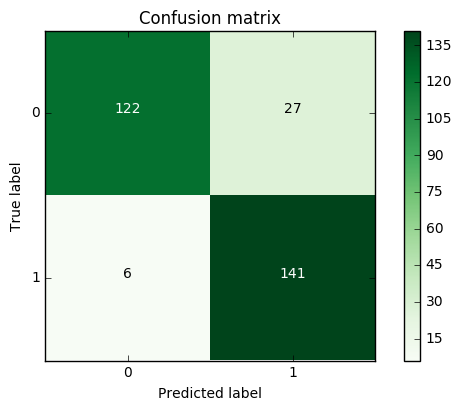

Recall metric in the testing dataset:  0.954545454545


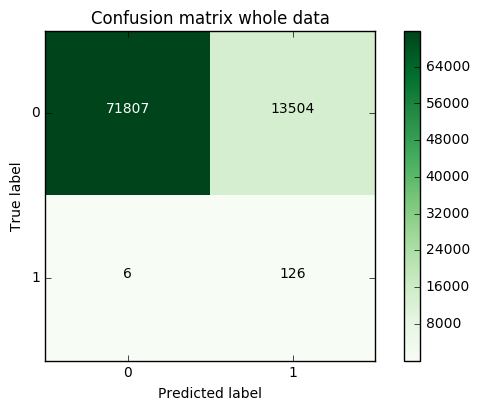

In [14]:
##################################plot confusion matrix###################################
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)  
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
##########plot

##########plot
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


# test on the whole test set
y_pred=lr.predict(X_test.values)

cnf_matrix_all=confusion_matrix(y_test,y_pred)
print("Recall metric in the testing dataset: ", cnf_matrix_all[1,1]/(cnf_matrix_all[1,0]+cnf_matrix_all[1,1]))

plt.figure()
plot_confusion_matrix(cnf_matrix_all,class_names,title='Confusion matrix whole data')
plt.show()


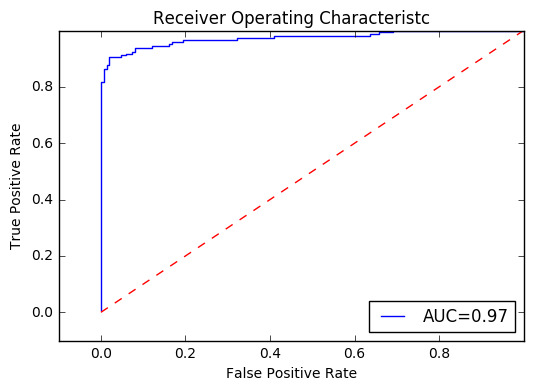

In [16]:
#plot roc curve : Receiver Operating Characteristic 
#auc:area under roc curve
#decision_function: confidence score
y_pred_undersample_score=lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)
#predict_proba for class 1
#y_pred_undersample_score=lr.fit(X_train_undersample,y_train_undersample.values.ravel()).predict_proba(X_test_undersample.values)[:,1]

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristc')
plt.plot(fpr,tpr,'b',label='AUC=%0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--') #diagonal
plt.xlim([-0.1,1.0]) 
plt.ylim([-0.1,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
